In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# === Global font setup ===
rcParams['font.family'] = 'Arial'
rcParams['axes.labelweight'] = 'bold'

# === Load data ===
df = pd.read_csv("ADMM_risk_aversion_results_O30_T672.csv")

# === Filter relevant columns ===
capacity_cols = ['PV', 'Wind', 'Gas', 'Nuclear', 'BESS_P', 'LDES_PHS_P']
df = df[['delta'] + capacity_cols]

# === Split data ===
df_rn = df[df['delta'] == 1].iloc[0]
df_others = df[df['delta'] != 1].sort_values('delta')

# === Define techs, labels, and colors ===
techs = ['BESS_P', 'Gas', 'Nuclear', 'LDES_PHS_P', 'PV', 'Wind']
labels = ['BESS', 'Gas', 'Nuclear', 'PHS', 'PV', 'OnshoreWind']
colors = {
    'BESS_P': '#4e79a7',       # Blue
    'Gas': '#af7aa1',          # Violet
    'Nuclear': '#bab0ac',      # Gray
    'LDES_PHS_P': '#e15759',   # Red
    'PV': '#f28e2b',           # Orange
    'Wind': '#76c7c0',         # Teal
}

# === Plot setup ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 6]})

for ax in [ax1, ax2]:
    ax.spines[['top', 'right']].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax.set_axisbelow(True)

# === Left: Risk Neutral ===
bar_width = 0.3
bottom = 0
for tech in techs:
    value = df_rn[tech]
    ax1.bar(0, value, width=bar_width, bottom=bottom, color=colors[tech])
    if value > 0.1:
        ax1.text(0, bottom + value / 2, f'{value:.2f}', ha='center', va='center', color='black', fontsize=10)
    bottom += value
ax1.set_xticks([0])
ax1.set_xticklabels(['Risk neutral'], fontsize=10)
ax1.set_ylabel("Capacity [MW]", fontsize=12, fontweight='bold')
ax1.set_title("New installed capacities", fontsize=13, fontweight='normal')
ax1.tick_params(labelsize=10)

# === Right: Differences ===
deltas = df_others['delta'].unique()
x = np.arange(len(deltas))
width = 0.5

bottom_pos = np.zeros_like(x, dtype=float)
bottom_neg = np.zeros_like(x, dtype=float)

for tech in techs:
    diffs = -(df_others[tech].values - df_rn[tech])
    for i, diff in enumerate(diffs):
        if diff >= 0:
            ax2.bar(x[i], diff, width=width, bottom=bottom_pos[i], color=colors[tech])
            if abs(diff) > 0.1:
                ax2.text(x[i], bottom_pos[i] + diff / 2, f'+{diff:.2f}', ha='center', va='center', fontsize=9)
            bottom_pos[i] += diff
        else:
            ax2.bar(x[i], diff, width=width, bottom=bottom_neg[i], color=colors[tech])
            if abs(diff) > 0.1:
                ax2.text(x[i], bottom_neg[i] + diff / 2, f'{diff:.2f}', ha='center', va='center', fontsize=9)
            bottom_neg[i] += diff

ax2.set_xticks(x)
ax2.set_xticklabels([f"{d:.1f}" for d in deltas], fontsize=10)
ax2.set_xlabel("Weight given to expected value in risk measure", fontsize=11, fontweight='normal')
ax2.set_ylabel("Capacity Difference [MW]", fontsize=12, fontweight='bold')
ax2.set_title("Fully Incomplete Markets Case\nDifference from Risk Neutral", fontsize=13, fontweight='normal')
ax2.axhline(0, color='gray', linewidth=1)

# === Legend ===
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[t]) for t in techs]
fig.legend(handles, labels, loc='upper center', ncol=len(techs), fontsize=11, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


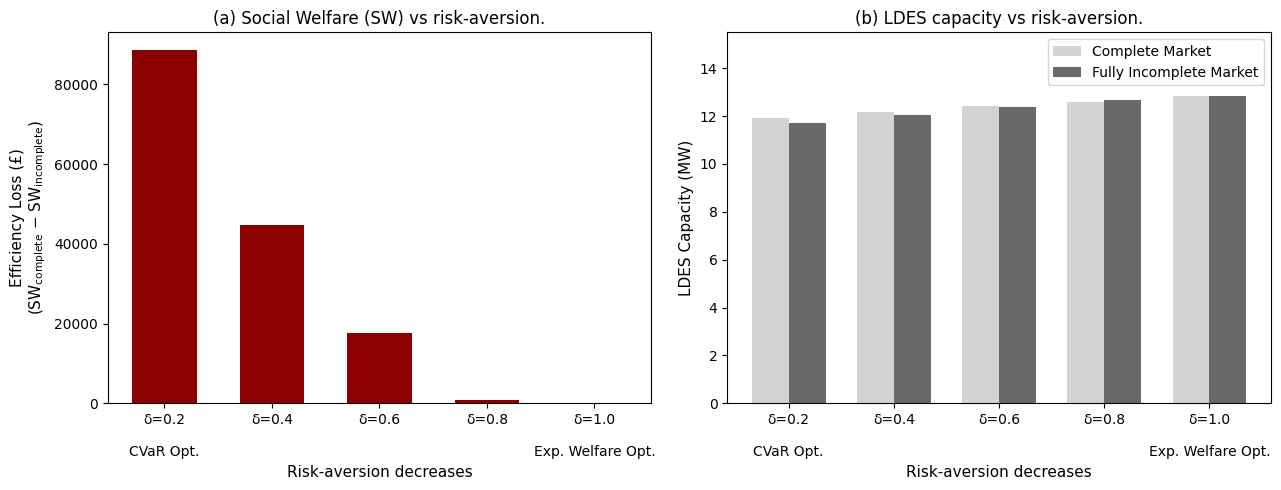

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the datasets
df_incomplete = pd.read_csv("ADMM_risk_aversion_results_O30_T672.csv")
df_complete = pd.read_csv("risk_aversion_results_O30_T672_new_final.csv")

# Sort by risk-aversion parameter (delta)
df_complete_sorted = df_complete.sort_values("delta")
df_incomplete_sorted = df_incomplete.sort_values("delta")

# Extract data
risk_aversion_levels = df_complete_sorted["delta"].values
welfare_complete = df_complete_sorted["objective"].values
welfare_incomplete = df_incomplete_sorted["social_wel"].values
efficiency_loss = welfare_complete - welfare_incomplete

ldes_capacity_complete = df_complete_sorted["LDES_PHS_P"].values
ldes_capacity_incomplete = df_incomplete_sorted["LDES_PHS_P"].values

ldes_energy_complete = df_complete_sorted["LDES_PHS_E"].values
ldes_energy_incomplete = df_incomplete_sorted["LDES_PHS_E"].values

# Create combined x-tick labels with delta
xtick_labels = []
for i, delta in enumerate(risk_aversion_levels):
    if i == 0:
        label = f"δ={delta:.1f}\n\nCVaR Opt."
    elif i == len(risk_aversion_levels) - 1:
        label = f"δ={delta:.1f}\n\nExp. Welfare Opt."
    else:
        label = f"δ={delta:.1f}"
    xtick_labels.append(label)

# Plot setup
num_ticks = len(risk_aversion_levels)
x = np.arange(num_ticks)
bar_width = 0.35

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# --- Plot (a) Social Welfare Efficiency Loss ---
axs[0].bar(x, efficiency_loss, color="#8B0000", width=0.6)
axs[0].set_title("(a) Social Welfare (SW) vs risk-aversion.", fontsize=12)
axs[0].set_xlabel("Risk-aversion decreases", fontsize=11)
axs[0].set_ylabel("Efficiency Loss (£)\n(SW$_{\\mathrm{complete}}$ − SW$_{\\mathrm{incomplete}}$)", fontsize=11)
axs[0].set_xticks(x)
axs[0].set_xticklabels(xtick_labels)
axs[0].tick_params(axis='both', labelsize=10)

# --- Plot (b) LDES Capacity ---
axs[1].bar(x - bar_width/2, ldes_capacity_complete, bar_width, label="Complete Market", color="lightgray")
axs[1].bar(x + bar_width/2, ldes_capacity_incomplete, bar_width, label="Fully Incomplete Market", color="dimgray")
axs[1].set_title("(b) LDES capacity vs risk-aversion.", fontsize=12)
axs[1].set_xlabel("Risk-aversion decreases", fontsize=11)
axs[1].set_ylabel("LDES Capacity (MW)", fontsize=11)
axs[1].set_xticks(x)
axs[1].set_ylim(0,15.5)
axs[1].set_xticklabels(xtick_labels)
axs[1].legend(fontsize=10)
axs[1].tick_params(axis='both', labelsize=10)

plt.tight_layout()


plt.show()

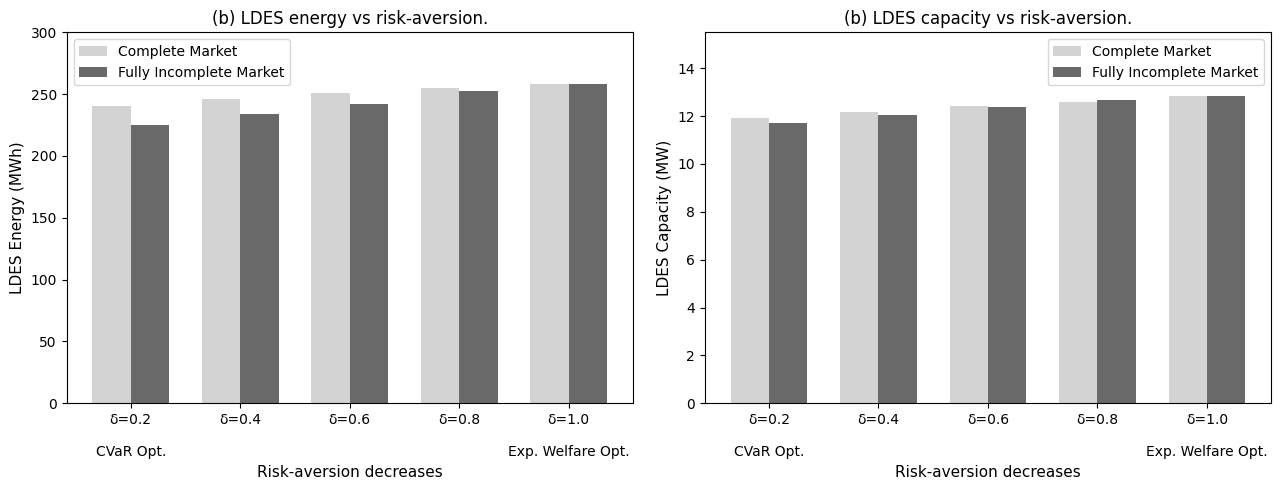

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the datasets
df_incomplete = pd.read_csv("ADMM_risk_aversion_results_O30_T672.csv")
df_complete = pd.read_csv("risk_aversion_results_O30_T672_new_final.csv")

# Sort by risk-aversion parameter (delta)
df_complete_sorted = df_complete.sort_values("delta")
df_incomplete_sorted = df_incomplete.sort_values("delta")

# Extract data
risk_aversion_levels = df_complete_sorted["delta"].values
welfare_complete = df_complete_sorted["objective"].values
welfare_incomplete = df_incomplete_sorted["social_wel"].values
efficiency_loss = welfare_complete - welfare_incomplete

ldes_capacity_complete = df_complete_sorted["LDES_PHS_P"].values
ldes_capacity_incomplete = df_incomplete_sorted["LDES_PHS_P"].values

ldes_energy_complete = df_complete_sorted["LDES_PHS_E"].values
ldes_energy_incomplete = df_incomplete_sorted["LDES_PHS_E"].values

# Create combined x-tick labels with delta
xtick_labels = []
for i, delta in enumerate(risk_aversion_levels):
    if i == 0:
        label = f"δ={delta:.1f}\n\nCVaR Opt."
    elif i == len(risk_aversion_levels) - 1:
        label = f"δ={delta:.1f}\n\nExp. Welfare Opt."
    else:
        label = f"δ={delta:.1f}"
    xtick_labels.append(label)

# Plot setup
num_ticks = len(risk_aversion_levels)
x = np.arange(num_ticks)
bar_width = 0.35

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# --- Plot (a) Social Welfare Efficiency Loss ---
axs[0].bar(x - bar_width/2, ldes_energy_complete, bar_width, label="Complete Market", color="lightgray")
axs[0].bar(x + bar_width/2, ldes_energy_incomplete, bar_width, label="Fully Incomplete Market", color="dimgray")
axs[0].set_title("(b) LDES energy vs risk-aversion.", fontsize=12)
axs[0].set_xlabel("Risk-aversion decreases", fontsize=11)
axs[0].set_ylabel("LDES Energy (MWh)", fontsize=11)
axs[0].set_xticks(x)
axs[0].set_ylim(0,300)
axs[0].set_xticklabels(xtick_labels)
axs[0].legend(fontsize=10)
axs[0].tick_params(axis='both', labelsize=10)

# --- Plot (b) LDES Capacity ---
axs[1].bar(x - bar_width/2, ldes_capacity_complete, bar_width, label="Complete Market", color="lightgray")
axs[1].bar(x + bar_width/2, ldes_capacity_incomplete, bar_width, label="Fully Incomplete Market", color="dimgray")
axs[1].set_title("(b) LDES capacity vs risk-aversion.", fontsize=12)
axs[1].set_xlabel("Risk-aversion decreases", fontsize=11)
axs[1].set_ylabel("LDES Capacity (MW)", fontsize=11)
axs[1].set_xticks(x)
axs[1].set_ylim(0,15.5)
axs[1].set_xticklabels(xtick_labels)
axs[1].legend(fontsize=10)
axs[1].tick_params(axis='both', labelsize=10)

plt.tight_layout()


plt.show()